In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.transforms import Bbox
from matplotlib.transforms import Affine2D
from matplotlib.collections import QuadMesh
import seaborn as sns
import scanpy as sc
import scipy
from scipy.spatial.distance import cdist, pdist, squareform
import sklearn

from importlib import reload

import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/hsc_landscape.anndata.h5ad"

adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()

adata

Memory usage: current 8.75 GB, difference +8.75 GB


AnnData object with n_obs × n_vars = 54347 × 19070
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'B_mem', 'B_naive', 'Baso', 'DC', 'Endo', 'Eos', 'Ery', 'Fibro', 'HSC', 'Macro', 'Mega', 'Mono', 'MDSC', 'Neut', 'Osteo', 'Plasma', 'pDC', 'Retic', 'Stromal', 'cluster_genes'
    uns: 'cell_type_colors', 'dataset_colors', 'go_annotations', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'organ_tissue_colors', 'panglaodb', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

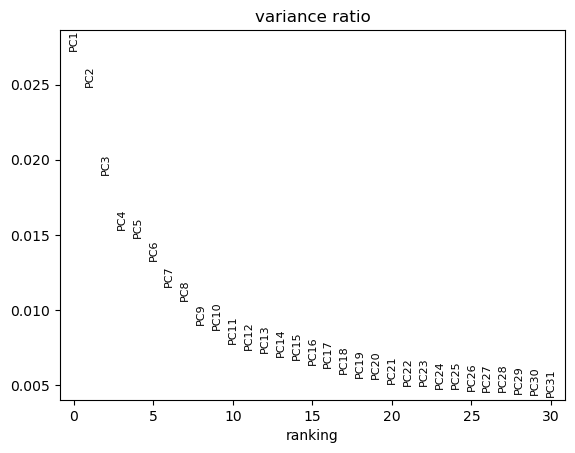

In [3]:
sc.pl.pca_variance_ratio(adata, n_pcs=30)

# Set up distance computations in PCA space

In [4]:
X_ihsc = adata[adata.obs['cell_type'] == 'iHSC', :].obsm['X_pca']
X_hsc = adata[adata.obs['cell_type'] == 'HSC', :].obsm['X_pca']
X_fib = adata[adata.obs['cell_type'] == 'FB', :].obsm['X_pca']

print(f"{X_ihsc.shape=}")
print(f"{X_hsc.shape=}")
print(f"{X_fib.shape=}")

X_ihsc.shape=(8574, 50)
X_hsc.shape=(5798, 50)
X_fib.shape=(26586, 50)


# Centroids

In [5]:
X_hsc_centroid = X_hsc.mean(axis=0).reshape(1, -1)
X_fib_centroid = X_fib.mean(axis=0).reshape(1, -1)

print(f"{X_hsc_centroid.shape=}")
print(f"{X_fib_centroid.shape=}")

X_hsc_centroid.shape=(1, 50)
X_fib_centroid.shape=(1, 50)


# Distances to centroids

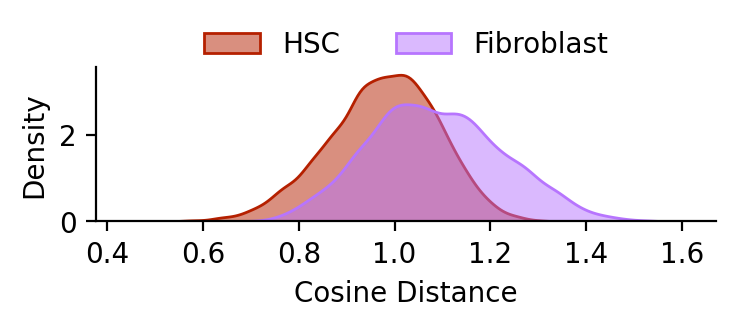

In [6]:
metric = 'cosine'
D_2_hsc = np.ravel(cdist(X_ihsc, X_hsc_centroid, metric=metric))
D_2_fib = np.ravel(cdist(X_ihsc, X_fib_centroid, metric=metric))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 1

# Colors (using hex codes for better control)
hsc_color = "#B52000"  # A pleasant blue
fibroblast_color = "#B775FE"  # A warm orange

sns.kdeplot(
    x=D_2_hsc, 
    label='HSC',
    color=hsc_color,
    fill=True,
    alpha=0.5,
)  

sns.kdeplot(
    x=D_2_fib, 
    label='Fibroblast', 
    color=fibroblast_color, 
    fill=True,
    alpha=0.5,
) 

plt.legend(frameon=False, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.4))
sns.despine()
plt.xlabel('Cosine Distance')
plt.show()

# Distance Matrix

In [7]:
metric = 'euclidean'

types = [
    'FB',
    'HSC',
    # 'LinNegCD34PosCD164Pos',
    # 'LinNegCD34lowCD164high',
    'MKP',
    'MLP',
    'MPP',
    'iHSC'
]

n = len(types)

D = np.zeros((n, n))

for i, cti in enumerate(types):
    i_data = adata[adata.obs['cell_type'] == cti, :]
    
    for j, ctj in enumerate(types):
        print(cti, ctj)
        j_data = adata[adata.obs['cell_type'] == ctj, :]
        
        d_ij = cdist(
            i_data.obsm['X_pca'], 
            j_data.obsm['X_pca'],
            metric=metric,
        )
        
        D[i, j] = np.mean(d_ij)
        
print(f"{D.shape=}")

FB FB
FB HSC
FB MKP
FB MLP
FB MPP
FB iHSC
HSC FB
HSC HSC
HSC MKP
HSC MLP
HSC MPP
HSC iHSC
MKP FB
MKP HSC
MKP MKP
MKP MLP
MKP MPP
MKP iHSC
MLP FB
MLP HSC
MLP MKP
MLP MLP
MLP MPP
MLP iHSC
MPP FB
MPP HSC
MPP MKP
MPP MLP
MPP MPP
MPP iHSC
iHSC FB
iHSC HSC
iHSC MKP
iHSC MLP
iHSC MPP
iHSC iHSC
D.shape=(6, 6)


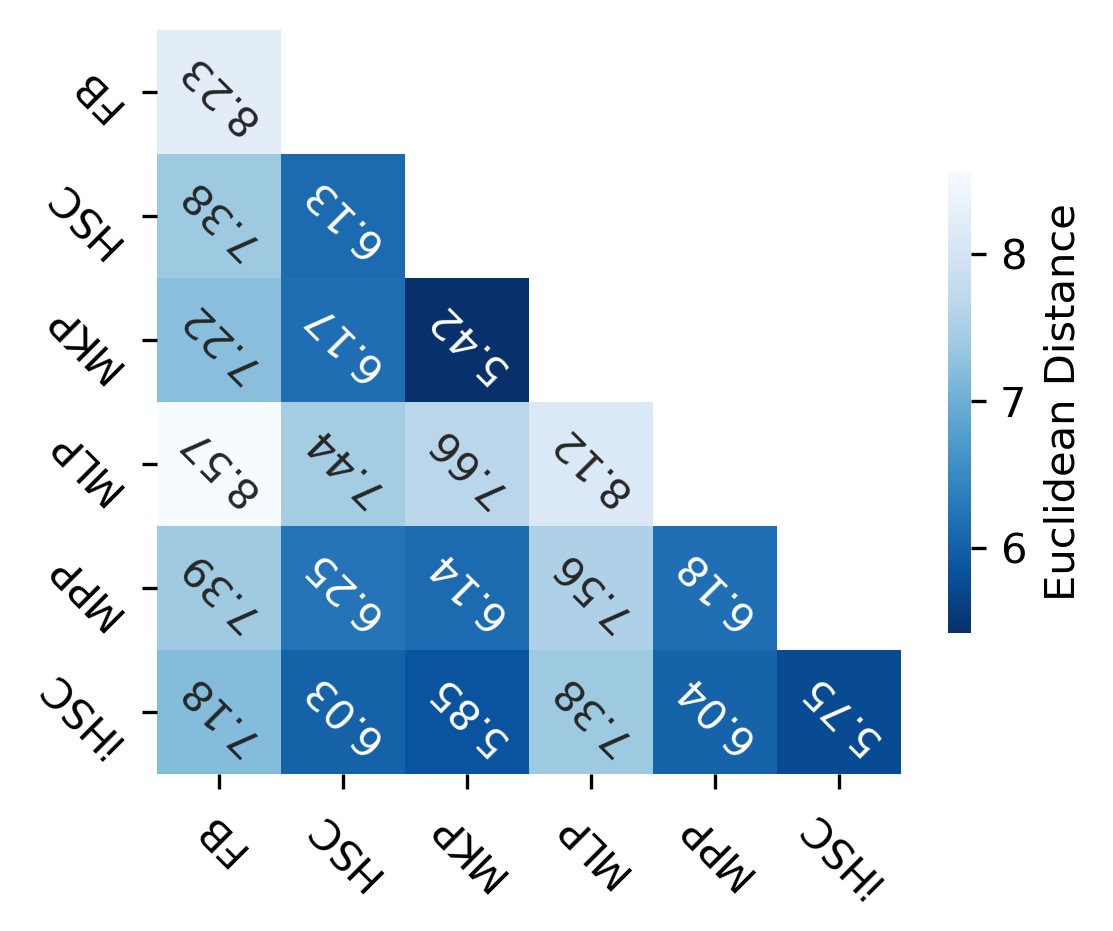

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

D_df = pd.DataFrame(
    D, 
    index=types, 
    columns=types,
)

# Create a mask for the upper triangle AND the diagonal
mask = np.triu(np.ones_like(D, dtype=bool), k=1)

ax = sns.heatmap(
    D_df,
    mask=mask,  # Apply the modified mask
    square=True,
    # linecolor='k',
    # lw=1,
    fmt=".2f",
    annot=True,
    cmap='Blues_r',
    cbar_kws={'shrink': 0.5, 'label' : 'Euclidean Distance'}
)

# Rotate the annotation text
for text in ax.texts: 
    text.set_rotation(135)  # Set the desired rotation angle (45 degrees in this example)

ax.tick_params(axis='y', rotation=135)
ax.tick_params(axis='x', rotation=135)
    
plt.show()

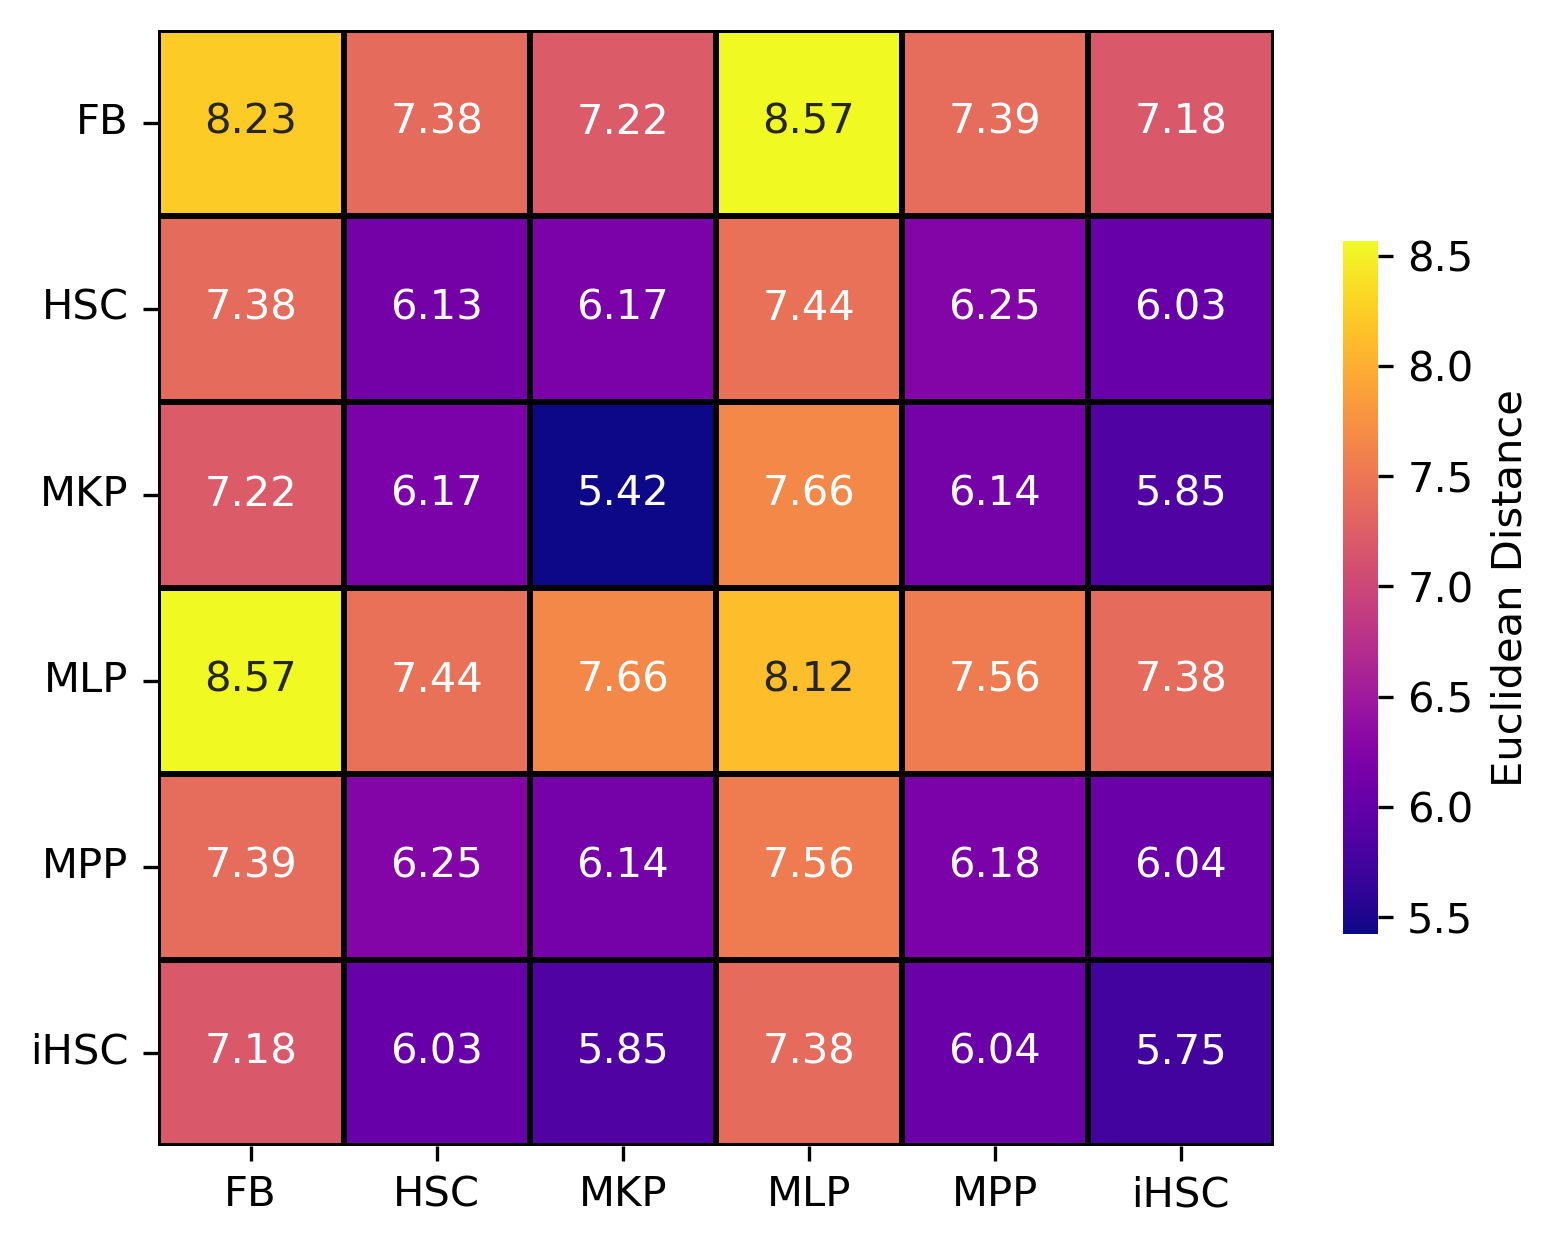

In [14]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6

ax = sns.heatmap(
    D_df,
    square=True,
    linecolor='k',
    lw=1,
    fmt=".2f",
    annot=True,
    cmap='plasma',
    cbar_kws={'shrink': 0.5, 'label' : 'Euclidean Distance'}
)


ax.tick_params(axis='y', rotation=0)
    
plt.show()

In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
tdata = adata.copy()
types = ['iHSC', 'HSC', 'FB']
tdata = tdata[tdata.obs['cell_type'].isin(types), :]
tdata = tdata[tdata.obs.sort_values(by='cell_type').index, :]
tdata

In [ ]:
D = squareform(pdist(tdata.obsm['X_pca'], metric=metric))
D.shape

In [ ]:
plt.imshow(D)

In [ ]:
type(tdata.obsp['distances'])

In [ ]:
plt.spy(tdata.obsp['distances'].todense())